In [30]:
### Test notbook for disorder implementation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [31]:
# ======================================================================
# 1. Physical constants
# ======================================================================
hbar = 6.58211899e-16       # eV·s
m0 = 9.10938215e-31          # kg
e0 = 1.602176487e-19         # C
eta_m = hbar**2 * e0 * 1e20 / m0   # ħ²/m₀ in eV·Å²
mu_B = 5.7883818066e-2       # meV/T
meV_per_K = 8.6173325e-2     # meV/K


#vdis1_b_strdis
#vdis4_nb_strdis
#vdis4_nb_strdis


In [32]:
# ======================================================================
# 2. System parameters
# ======================================================================
Nx = 300         # wire length (Lx = 2 µm)
Ny = 1        # wire width (Ly = 124 nm)
ax = 100.0  #40       # unit cell (Å)
ay = 100.0  #40      # unit cell (Å)
ms = 0.023        # effective mass (m*/m₀)

# hopping (meV)
tx = 1000 * eta_m / (2 * ax**2 * ms)
ty = 1000 * eta_m / (2 * ay**2 * ms)

# Rashba spin–orbit coupling (meV)
alpha_x = 140.0 / ax
alpha_y = 140.0 / ay

# superconducting parameters
Delta_00 = 0.25   # parent SC gap (meV)
Gamma = 0.75      # SM–SC coupling


In [33]:
# ======================================================================
# 3. Generate uniform random SM impurities
# ======================================================================
Nimp = 52
Rimp = np.column_stack((
    np.random.uniform(0, Nx + 1, Nimp),
    np.random.uniform(0, Ny + 1, Nimp)
))

Rimp


array([[1.10717882e+02, 4.10073213e-01],
       [8.84407799e+01, 4.09835450e-01],
       [1.81606602e+01, 3.41629670e-01],
       [8.59745136e+01, 1.04580821e+00],
       [2.99980115e+02, 1.41123158e+00],
       [3.49183828e+01, 1.91492815e+00],
       [2.52055304e+02, 2.42120703e-01],
       [2.66375293e+02, 1.85051324e-01],
       [2.73049904e+02, 1.47545555e+00],
       [2.75236170e+02, 1.41098656e+00],
       [1.48837172e+02, 1.73089713e+00],
       [6.72464938e+01, 1.44793628e+00],
       [7.83659141e+01, 1.95427453e-01],
       [2.03007078e+02, 1.74043898e+00],
       [1.04701848e+02, 9.55405544e-01],
       [1.61854958e+02, 1.76219381e+00],
       [1.82146507e+02, 1.25522450e+00],
       [1.33652418e+02, 7.06438966e-01],
       [1.58745608e+02, 1.26166318e+00],
       [3.99059548e+01, 4.84515117e-01],
       [6.52101882e+01, 1.77539014e+00],
       [1.92351701e+02, 6.98107844e-01],
       [1.93914617e+02, 1.00342633e+00],
       [8.13820293e+01, 1.00139817e+00],
       [1.836565

In [34]:
#Nimp = 52
#Rimp = np.column_stack((
#    np.random.uniform(0, Nx + 1, Nimp),
#    np.zeros(shape = (Nimp))
#))
#



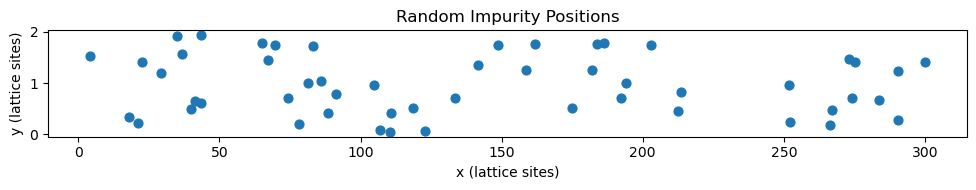

In [35]:
#print(Rimp)

# plot impurity positions
plt.figure(figsize=(10, 2))
plt.scatter(Rimp[:, 0], Rimp[:, 1], color='tab:blue', s=40)
plt.xlabel("x (lattice sites)")
plt.ylabel("y (lattice sites)")
plt.title("Random Impurity Positions")
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

In [36]:

# ======================================================================
# 4. Disorder potential
# ======================================================================
#Lambda_dis = 180.0  # decay length (Å)
Lambda_dis = ax/0.2222222

def fVd(x):
    """Exponential decay function."""
    return np.exp(-x / Lambda_dis)

def generate_Vdis(Nx, Ny, Rimp, ax, ay):
    """Generate smooth random disorder potential."""
    Nimp = len(Rimp)
    vtp = np.zeros((Nx, Ny), dtype=float)

    x_grid = np.arange(1, Nx + 1)[:, None]
    
    if Ny == 0:
        y_grid = np.zeros(1)
        
    else:
        y_grid = np.arange(1, Ny + 1)[None, :]
        

    for kk in range(Nimp):
        sign = (-1)**(kk + 1)
        #sign = np.random.choice([1,-1]) #<--- use this instead?
        dd = np.sqrt((x_grid - Rimp[kk, 0])**2 * ax**2 +
                     (y_grid - Rimp[kk, 1])**2 * ay**2)
        vtp += sign * fVd(dd)

    # subtract mean and normalize variance
    vtp -= np.mean(vtp)
    vtp /= np.sqrt(np.mean(vtp**2))
    return vtp

In [37]:
Vdis = generate_Vdis(Nx, Ny, Rimp, ax, ay)

# Construct Vdis4 (2Ny × Nx)
v2 = np.zeros((Nx, 2 * Ny))
for ii in range(Nx):
    jj_index = (np.arange(1, 2 * Ny + 1) // 2)
    v2[ii, :] = Vdis[ii, np.clip(jj_index, 0, Ny - 1)]
Vdis4 = np.hstack((v2, -v2))


Vdis.shape

(300, 1)

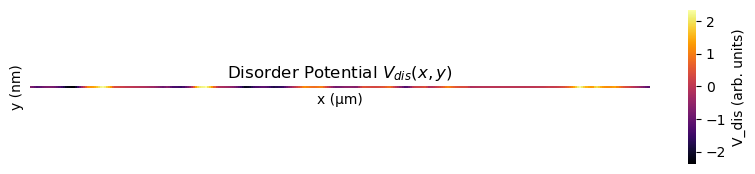

In [38]:
# ======================================================================
# 5. Plot Vdis (DensityPlot)
# ======================================================================

plt.figure(figsize=(10, 2))
sns.heatmap(
    Vdis.T,
    cmap="inferno",
    cbar=True,
    cbar_kws={'label': 'V_dis (arb. units)'},
    xticklabels=False,
    yticklabels=False
    
)
plt.xlabel("x (μm)")
plt.ylabel("y (nm)")
plt.title("Disorder Potential $V_{dis}(x, y)$")
plt.gca().set_aspect(0.75)
plt.show()

In [39]:
Tdis = np.asarray([0.452874, 0.21002, -0.284492, -0.659038, -0.786086, -0.525799, 
-0.38377, 0.0566635, 0.322575, 0.47192, 0.662315, 0.384357, 
-0.312115, -0.69525, -0.574579, -0.17187, 0.265048, 0.498968, 
0.349402, -0.28886, -1.02809, -1.28968, -0.995924, -0.430435, 
0.0916559, 0.578167, 1.03006, 1.11903, 0.73348, 0.142864, -0.156246, 
-0.0399484, -0.0154498, -0.170972, -0.0951919, 0.374153, 0.828708, 
0.671003, 0.0261068, -0.49542, -0.653214, -0.531546, -0.146962, 
0.517033, 1.07006, 1.16082, 0.970738, 0.491015, -0.438995, -1.228, 
-0.93252, 0.116177, 0.677326, 0.473787, 0.894253, 1.30834, 1.50161, 
1.14759, 0.49782, 0.21694, 0.21838, -0.0467326, -0.757523, -1.56948, 
-1.70291, -0.828864, 0.438255, 1.38332, 1.64262, 1.04052, -0.196065, 
-1.13378, -1.15416, -0.607921, 0.104589, 0.737551, 1.12481, 1.34214, 
1.57144, 1.87796, 2.14067, 1.97054, 1.26508, 0.453383, -0.207544, 
-0.695028, -0.766371, -0.643513, -0.870116, -0.918961, -0.3858, 
0.0218848, -0.0283636, -0.158753, 0.0372964, 0.700059, 1.39411, 
1.42632, 0.871495, 0.513397, 0.428477, 0.209594, 0.114257, 0.26281, 
0.24527, -0.0700469, -0.446987, -0.766343, -1.07829, -1.33398, 
-1.37623, -1.32052, -1.41463, -1.51993, -1.34015, -0.996566, 
-1.04251, -1.70012, -2.46144, -2.55056, -2.55056, -2.03636, -1.13528, 
-0.376687, 0.37462, 0.862945, 0.773755, 0.621231, 0.943651, 1.36241, 
1.29923, 0.842148, 0.519563, -0.830196, -1.14864, -1.65801, -1.27588, 
0.448467, 0.360344, -0.139305, -0.553087, -0.499198, -0.366472, 
-0.761165, -0.91112, 0.0754531, 1.28353, 1.64107, 1.06869, -0.370529, 
-1.92947, -2.31937, -1.74207, -1.29614, -1.10253, -0.902068, 
-0.611232, -0.107775, 0.618683, 1.42857, 2.07159, 2.36802, 2.48358, 
2.40696, 1.83057, 0.92405, 0.365879, 0.657959, 1.45747, 1.84893, 
1.66872, 1.16706, 0.30081, -0.519329, -0.702022, -0.509419, 
-0.610614, -0.861853, -0.840651, -0.821486, -0.848154, -0.429494, 
0.338117, 0.83166, 0.743637, 0.32598, 0.173883, 0.612693, 1.04265, 
0.711198, -0.191321, -0.635027, -0.202864, 0.314312, 0.37837, 
0.367477, 0.495562, 0.391449, -0.149983, -0.646626, -0.498146, \
-0.0884465, -0.113862, -0.247957, -0.179923, -0.379681, -1.12113, \
-1.72834, -1.66511, -1.40732, -1.24693, -0.961002, -0.453292, \
0.294333, 0.952484, 0.926187, 0.307074, -0.270116, -0.451926, \
-0.248375, -0.504476, -0.317154, 0.0696261, 2.04143, 2.02502, \
0.922446, 0.408673, 0.996308, 1.36585, 0.597821, -0.64502, -1.62492, \
-1.85679, -0.855313, 0.702727, 1.47753, 1.25715, 0.907288, 0.941967, \
0.975336, 0.603644, 0.042137, -0.281761, -0.236557, -0.0327036, \
-0.0381532, -0.304866, 0.36493, -0.268754, -0.619861, -0.563511, \
-0.565465, -0.965443, -1.21149, -0.920027, -0.579462, -0.232793, \
0.454877, 1.12119, 1.32896, 1.20331, 0.872942, 0.663642, 1.17223, \
1.70069, 1.14962, 0.0737236, -0.776288, -1.35719, -1.19802, \
-0.374519, -0.343096, 0.0703165, 0.377709, 0.313998, 0.13212, \
-0.159962, -0.671412, -0.916253, -0.279789, 1.01931, 1.95293, 1.7881, \
0.916355, 0.3977869, 0.490675, 0.2577821, -0.530294, -1.18016, \
-1.60528, -2.04495, -2.32656, -2.33286, -1.98784, -1.17538, \
-0.332732, 0.0751958, 0.145942, 0.283438, 0.496432])

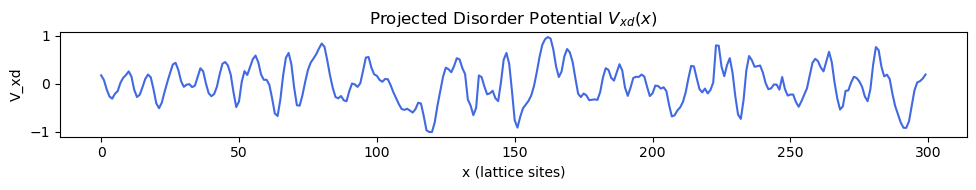

ΔVd = 0.0000
<Vxd²> = 0.1537


In [40]:
# ======================================================================
# 6. 1D projection: Vxd = sum_y Vdis(x, y) * Y0(y)
# ======================================================================
Y0 = np.ones(Ny)
Vxd = Tdis# np.array([np.dot(Vdis[ii, :], Y0) for ii in range(Nx)])
Vxd = Vxd/np.max(np.abs(Vxd))

plt.figure(figsize=(10, 2))
plt.plot(np.arange(Nx), Vxd, color='royalblue')
plt.xlabel("x (lattice sites)")
plt.ylabel("V_xd")
plt.title("Projected Disorder Potential $V_{xd}(x)$")
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

# mean and variance
DeltaVd = np.mean(Vxd)
VarVd = np.mean(Vxd**2)
print(f"ΔVd = {DeltaVd:.4f}")
print(f"<Vxd²> = {VarVd:.4f}")

In [48]:
dir = Path('/home/pseudonym/code/Nonlocal_Conductance/Nonlocality-of-local-Andreev-conductances-as-a-probe-for-topological-Majorana-wires/Run_Files')
pth = Path(dir, 'Tdis.npz')
np.savez(pth, Vdisx = Tdis)

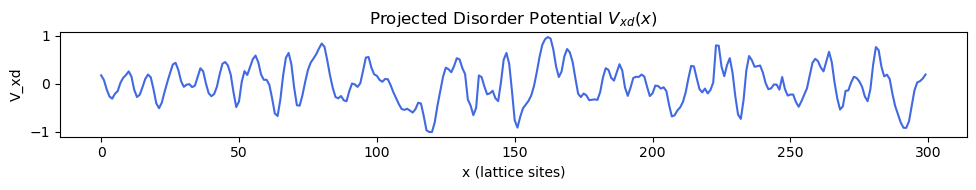

ΔVd = 0.0000
<Vxd²> = 0.1537


In [49]:
import helpers as hp
from pathlib import Path
loadpth = Path(dir, 'Tdis.npz')
dataloaded = hp.initialize_vdis_from_data(loadpth)

# ======================================================================
# 6. 1D projection: Vxd = sum_y Vdis(x, y) * Y0(y)
# ======================================================================
Y0 = np.ones(Ny)
Vxd = dataloaded#np.array([np.dot(Vdis[ii, :], Y0) for ii in range(Nx)])
Vxd = Vxd/np.max(np.abs(Vxd))

plt.figure(figsize=(10, 2))
plt.plot(np.arange(Nx), Vxd, color='royalblue')
plt.xlabel("x (lattice sites)")
plt.ylabel("V_xd")
plt.title("Projected Disorder Potential $V_{xd}(x)$")
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

# mean and variance
DeltaVd = np.mean(Vxd)
VarVd = np.mean(Vxd**2)
print(f"ΔVd = {DeltaVd:.4f}")
print(f"<Vxd²> = {VarVd:.4f}")